In [1]:
import subprocess
import time
import pandas as pd

# List of servers to ping
servers = [
    "vg.no", "aftenposten.no", "nordlys.no",
    "nytimes.com", "openai.com",
    "bbc.co.uk", "lemonde.fr", "zeit.de",
    "cnn.com", "aljazeera.com"
]

# Ping function
def ping_server(server):
    try:
        result = subprocess.run(["ping", "-c", "1", server], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            # Parse the time from the ping response
            for line in result.stdout.split("\n"):
                if "time=" in line:
                    latency = line.split("time=")[1].split(" ")[0]  # Extract latency in ms
                    return float(latency)
        return None  # If no latency found
    except Exception as e:
        return None

# Data collection
def collect_ping_data(servers, duration=60, interval=10):
    """Ping servers for a duration, collecting data at intervals."""
    data = []
    start_time = time.time()
    while time.time() - start_time < duration:
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        for server in servers:
            latency = ping_server(server)
            data.append({"timestamp": timestamp, "server": server, "latency_ms": latency})
        time.sleep(interval)
    return pd.DataFrame(data)

In [3]:
# Collect data for 1 minute with 10-second intervals (example)
ping_data = collect_ping_data(servers, duration=60, interval=10)

# Save data to CSV
file_path = "ping_data.csv"
ping_data.to_csv(file_path, index=False)

file_path

'ping_data.csv'

In [9]:
ping_data.to_csv()

',timestamp,server,latency_ms\n0,2024-11-24 20:01:41,vg.no,17.6\n1,2024-11-24 20:01:41,aftenposten.no,15.6\n2,2024-11-24 20:01:41,nordlys.no,\n3,2024-11-24 20:01:41,nytimes.com,17.3\n4,2024-11-24 20:01:41,openai.com,17.2\n5,2024-11-24 20:01:41,bbc.co.uk,15.9\n6,2024-11-24 20:01:41,lemonde.fr,41.6\n7,2024-11-24 20:01:41,zeit.de,51.9\n8,2024-11-24 20:01:41,cnn.com,16.9\n9,2024-11-24 20:01:41,aljazeera.com,\n10,2024-11-24 20:02:11,vg.no,20.0\n11,2024-11-24 20:02:11,aftenposten.no,17.2\n12,2024-11-24 20:02:11,nordlys.no,\n13,2024-11-24 20:02:11,nytimes.com,16.0\n14,2024-11-24 20:02:11,openai.com,15.1\n15,2024-11-24 20:02:11,bbc.co.uk,16.0\n16,2024-11-24 20:02:11,lemonde.fr,43.1\n17,2024-11-24 20:02:11,zeit.de,40.3\n18,2024-11-24 20:02:11,cnn.com,16.7\n19,2024-11-24 20:02:11,aljazeera.com,\n'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

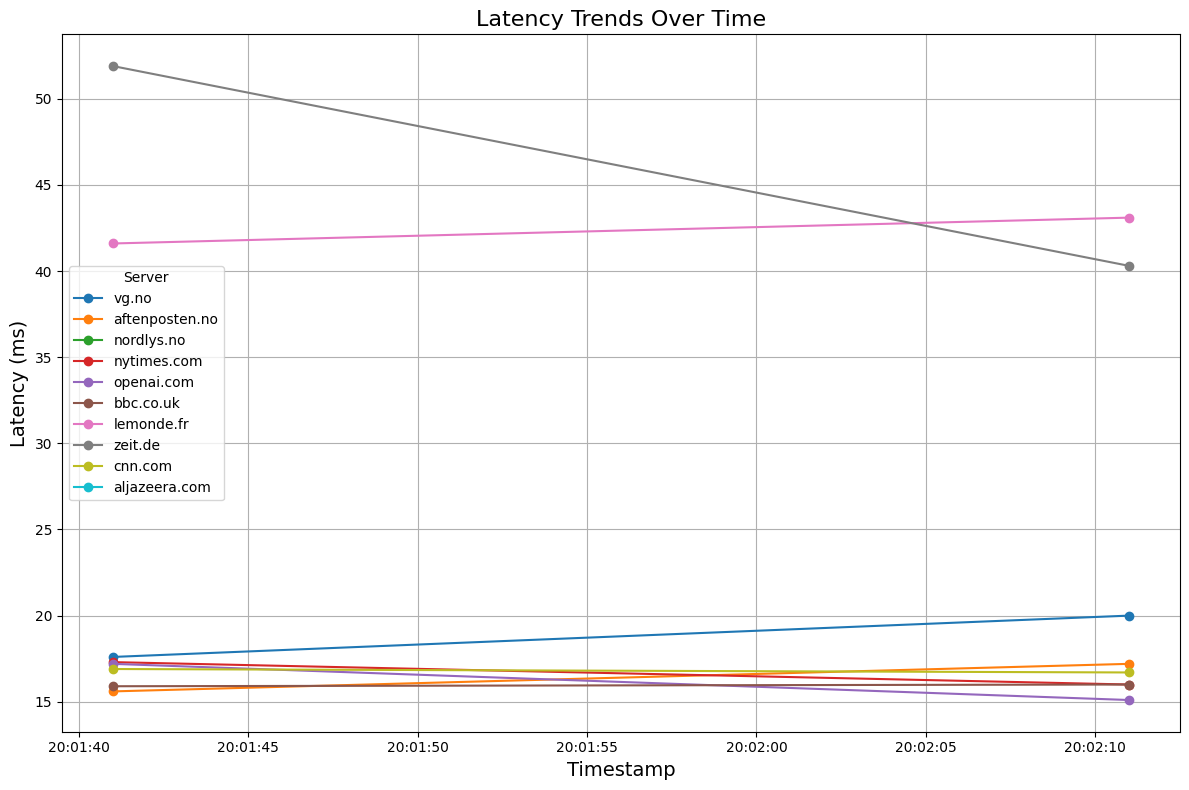

In [ ]:
# Load the ping data
file_path = 'ping_data.csv'
ping_data = pd.read_csv(file_path)

# Clean up and process the data
ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'])
ping_data['latency_ms'] = pd.to_numeric(ping_data['latency_ms'], errors='coerce')

# Plot latency trends over time for each server
plt.figure(figsize=(12, 8))
for server in ping_data['server'].unique():
    server_data = ping_data[ping_data['server'] == server]
    plt.plot(server_data['timestamp'], server_data['latency_ms'], marker='o', label=server)

plt.title("Latency Trends Over Time", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Latency (ms)", fontsize=14)
plt.legend(title="Server", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import numpy as np
%matplotlib inline

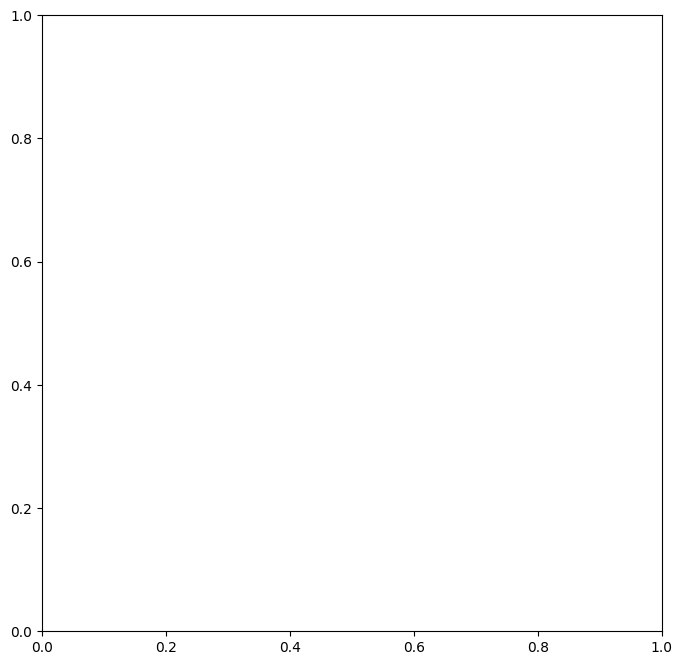

In [40]:
# Load the ping data again to prepare for the graph
ping_data = pd.read_csv(file_path)
ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'])
ping_data['latency_ms'] = pd.to_numeric(ping_data['latency_ms'], errors='coerce')

# Set up unique servers and central node (user)
servers = ping_data['server'].unique()
central_node = "You"

# Initialize the graph
G = nx.Graph()
G.add_node(central_node, pos=(0, 0))  # Central node at the origin

# Add server nodes
positions = {}
angle_step = 2 * np.pi / len(servers)
for i, server in enumerate(servers):
    angle = i * angle_step
    positions[server] = (np.cos(angle), np.sin(angle))  # Spread servers in a circle
    G.add_node(server, pos=positions[server])
    G.add_edge(central_node, server)  # Connect servers to the central node

# Function to update positions dynamically based on latency
def update_positions(latencies):
    for server in servers:
        latency = latencies.get(server, np.nan)
        if np.isnan(latency):
            factor = 0.2  # Push nodes with missing latency to the edge
        else:
            factor = 1 / (1 + latency / 50)  # Scale inversely with latency
        x, y = positions[server]
        G.nodes[server]['pos'] = (x * factor, y * factor)
    return nx.get_node_attributes(G, 'pos')

# Extract latency data over time
timestamps = ping_data['timestamp'].unique()
latency_over_time = [
    ping_data[ping_data['timestamp'] == timestamp].set_index('server')['latency_ms'].to_dict()
    for timestamp in timestamps
]

# Set up plot
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')

def draw_graph_debug(frame):
    ax.clear()
    latencies = latency_over_time[frame]
    print(f"Frame {frame}, Timestamp: {timestamps[frame]}, Latencies: {latencies}")  # Debug output
    pos = update_positions(latencies)
    print(f"Updated Positions: {pos}")  # Debug output

    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    ax.set_title(f"Internet Topology at {timestamps[frame]}", fontsize=14)
    ax.axis("off")

In [49]:
# Run animation with debug information
ani_debug = FuncAnimation(fig, draw_graph_debug, frames=len(timestamps), interval=1000, repeat=True)
ani_debug.save("animation.mp4")
plt.show()

Frame 0, Timestamp: 2024-11-24 20:01:41, Latencies: {'vg.no': 17.6, 'aftenposten.no': 15.6, 'nordlys.no': nan, 'nytimes.com': 17.3, 'openai.com': 17.2, 'bbc.co.uk': 15.9, 'lemonde.fr': 41.6, 'zeit.de': 51.9, 'cnn.com': 16.9, 'aljazeera.com': nan}
Updated Positions: {'You': (0, 0), 'vg.no': (np.float64(0.7396449704142012), np.float64(0.0)), 'aftenposten.no': (np.float64(0.6166288066882222), np.float64(0.4480070520521899)), 'nordlys.no': (np.float64(0.06180339887498949), np.float64(0.1902113032590307)), 'nytimes.com': (np.float64(-0.22958171944646902), np.float64(0.7065798783767857)), 'openai.com': (np.float64(-0.6019471684337407), np.float64(0.43734021747951884)), 'bbc.co.uk': (np.float64(-0.7587253414264036), np.float64(9.291705608098278e-17)), 'lemonde.fr': (np.float64(-0.4416031628684211), np.float64(-0.3208434783255857)), 'zeit.de': (np.float64(-0.15162757329487123), np.float64(-0.466661686111459)), 'cnn.com': (np.float64(0.23095440536244186), np.float64(-0.7108045712220878)), 'alja

In [37]:
draw_graph_debug(0)

Frame 0, Timestamp: 2024-11-24 20:01:41, Latencies: {'vg.no': 17.6, 'aftenposten.no': 15.6, 'nordlys.no': nan, 'nytimes.com': 17.3, 'openai.com': 17.2, 'bbc.co.uk': 15.9, 'lemonde.fr': 41.6, 'zeit.de': 51.9, 'cnn.com': 16.9, 'aljazeera.com': nan}
Updated Positions: {'You': (0, 0), 'vg.no': (np.float64(0.7396449704142012), np.float64(0.0)), 'aftenposten.no': (np.float64(0.6166288066882222), np.float64(0.4480070520521899)), 'nordlys.no': (np.float64(0.06180339887498949), np.float64(0.1902113032590307)), 'nytimes.com': (np.float64(-0.22958171944646902), np.float64(0.7065798783767857)), 'openai.com': (np.float64(-0.6019471684337407), np.float64(0.43734021747951884)), 'bbc.co.uk': (np.float64(-0.7587253414264036), np.float64(9.291705608098278e-17)), 'lemonde.fr': (np.float64(-0.4416031628684211), np.float64(-0.3208434783255857)), 'zeit.de': (np.float64(-0.15162757329487123), np.float64(-0.466661686111459)), 'cnn.com': (np.float64(0.23095440536244186), np.float64(-0.7108045712220878)), 'alja

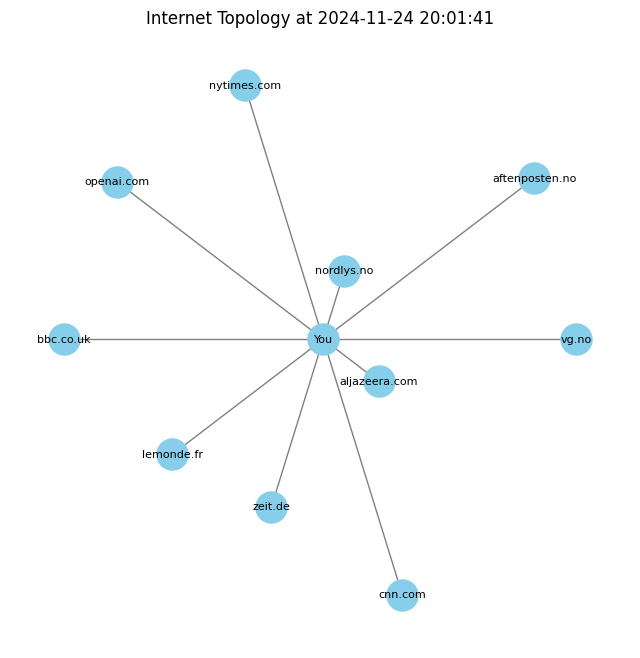

In [38]:
frame_to_test = 0
latencies = latency_over_time[frame_to_test]
pos = update_positions(latencies)

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title(f"Internet Topology at {timestamps[frame_to_test]}")
plt.axis("off")
plt.show()
